In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from sklearn.model_selection import train_test_split
import os
import math
import matplotlib.pyplot as plt
import time
import gc

import Modules.UNet as un

In [2]:
def randomSeedInitial(seed=256, cudnnDeterministic=True, cudnnBenchmark=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 为了保证可复现性, defaul True False; False True 可能可以提升gpu运行效率
    torch.backends.cudnn.deterministic = cudnnDeterministic
    torch.backends.cudnn.benchmark = cudnnBenchmark
    
begin_time = time.time()
randomSeedInitial(256)

In [3]:
# 单污染源
# 13x8
# train = np.load('./13x8/all/allconc.npy', allow_pickle=True)
# 15x25
# train = np.load('./15x25/all/allconc.npy', allow_pickle=True)
# 14x18
# train = np.load('./high/all/allconc.npy', allow_pickle=True)
# 多污染源
# 13x8
# train = np.load('./13x8d/all/allconc.npy', allow_pickle=True)
# 15x25
# train = np.load('./new15x25d/all/allconc.npy', allow_pickle=True)
train = np.load('./15x25d/all/allconc.npy', allow_pickle=True)

# 14x18
# train = np.load('./14x18d/all/allconc.npy', allow_pickle=True)

In [4]:
class MyDataset(Dataset):
    def __init__(self, x: np.numarray, y: np.numarray):
        """
        :param x: shape like (n_sample, t, n_well)
        :param y: shape like (n_sample, t, h, w)
        :param z: shape like (n, h, w)
        """
        super(MyDataset, self).__init__()
        self.x = torch.from_numpy(x).to(torch.float32)
        self.y = torch.from_numpy(y).to(torch.float32)

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, item):
        return self.x[item], self.y[item]

In [5]:
label = []
train_input = []

for k in range(len(train)):
    label.append(train[k][1])
    train_input.append(train[k][-1])
# label = (np.array(label)).reshape(100, 1, 18, 14)*100000
# train = (np.array(train_input)).reshape(100, 1, 18, 14)*100000
# label = (np.array(label)).reshape(100, 1, 18, 14)*1
# train = (np.array(train_input)).reshape(100,1,18,14)*1
# label = (np.array(label)).reshape(len(label), 1, 8, 13)*1000
# train = (np.array(train_input)).reshape(len(label),1,8,13)*1000
label = (np.array(label)).reshape(len(label), 1, 15, 25)*1000
train = (np.array(train_input)).reshape(len(train),1,15,25)*1000
# print(label.shape)
# print(train.shape)

# label = (np.array(label)).reshape(len(label), 15, 25)*100
# train = (np.array(train_input)).reshape(len(train),15,25)*100

mid = np.ones((1, 1, 4, 4))
# mid.dtype = 'float32'
label = np.kron(label, mid)
train = np.kron(train, mid)

# print(label.shape)
# print(train.shape)

X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=256)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, random_state=256)
train_data = MyDataset(X_train, y_train)
val_data = MyDataset(X_valid, y_valid)
test_data = MyDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_data, batch_size=7, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=5, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=False, drop_last=False)

In [7]:
def Conv2(img, kernel, n, stride,p):
    #img：输入图片；kernel：卷积核值；n：卷积核大小为n*n；stride:步长。
    #return：feature map
    h, w = img.shape
    res_h = ((h+2*p-n)//stride)+1 #卷积边长计算公式：((n+2*p-k)/stride)+1
    res_w = ((w+2*p -n)//stride)+1
    res = np.zeros([res_h, res_w])
    for i in range(res_h):
        for j in range(res_w):
            temp = img[i*stride:i*stride+n , j*stride:j*stride+n]
            temp = np.multiply(kernel, temp)
            res[i][j] = temp.sum()
    return res

In [8]:
model = un.UNet()
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 20], 0.1)
loss_func = nn.MSELoss()

In [9]:
os.makedirs('./output', exist_ok=True)
best = 10000000
lose = []
for epoch in range(2000):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch, (batch_x, batch_y) in enumerate(train_loader):
        if torch.cuda.is_available():
            batch_x, batch_y = Variable(batch_x.cuda()), Variable(batch_y.cuda())
        out = model(batch_x)  #

        loss = loss_func(out, batch_y)

        train_loss += loss.item()
        train_corret = abs(out - batch_y).sum()
        train_acc += train_corret.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with open('结果存放.txt','a') as file_handle:   # .txt可以不自己新建,代码会自动新建
            file_handle.write(str(out))     # 写入
            file_handle.write(str(batch_y))     # 写入
            file_handle.write('\n')
    lose.append(train_loss / (math.ceil(len(train_data) / 7)))
    print(f'Epoch: {epoch}', 'Train Loss: %.6f, Acc: %.3f' % (train_loss / (math.ceil(len(train_data) / 7)),
                                                              train_acc / (len(train_data))))
    
    #     evaluation
    model.eval()
    eval_loss = 0
    eval_acc = 0
    for batch_x, batch_y in val_loader:
        if torch.cuda.is_available():
            batch_x, batch_y = Variable(batch_x.cuda()), Variable(batch_y.cuda())

        out = model(batch_x)
        loss = loss_func(out, batch_y)
        eval_loss += loss.item()
        num_correct = abs(out - batch_y).sum()
        eval_acc += num_correct.item()
    print('Val Loss: %.6f, Acc: %.3f' % (eval_loss / (math.ceil(len(val_data) / 7)),
                                         eval_acc / (len(val_data))))
    print(eval_acc / (len(val_data)))
    if (eval_acc / (len(val_data))) < best:
        best = eval_acc / (len(val_data))
        print(best, eval_acc / (len(val_data)))
        torch.save(model.state_dict(), 'output/15x25/UNetid1.pth')
    gc.collect()
    torch.cuda.empty_cache()

Epoch: 0 Train Loss: 79396.142920, Acc: 672406.196
Val Loss: 29617.350586, Acc: 480585.850
480585.85
480585.85 480585.85
Epoch: 1 Train Loss: 13147.189819, Acc: 283979.059
Val Loss: 1346.896362, Acc: 99877.825
99877.825
99877.825 99877.825
Epoch: 2 Train Loss: 3455.118051, Acc: 129414.839
Val Loss: 900.065430, Acc: 78370.100
78370.1
78370.1 78370.1
Epoch: 3 Train Loss: 1630.656046, Acc: 90222.666
Val Loss: 1172.080383, Acc: 82557.163
82557.1625
Epoch: 4 Train Loss: 766.020425, Acc: 60509.657
Val Loss: 693.102142, Acc: 70039.531
70039.53125
70039.53125 70039.53125
Epoch: 5 Train Loss: 458.914658, Acc: 45089.199
Val Loss: 337.501343, Acc: 37551.622
37551.621875
37551.621875 37551.621875
Epoch: 6 Train Loss: 310.206741, Acc: 36949.503
Val Loss: 246.261757, Acc: 27302.394
27302.39375
27302.39375 27302.39375
Epoch: 7 Train Loss: 272.432970, Acc: 31130.674
Val Loss: 262.680069, Acc: 35089.772
35089.771875
Epoch: 8 Train Loss: 238.896596, Acc: 28995.724
Val Loss: 223.011078, Acc: 25996.328
25

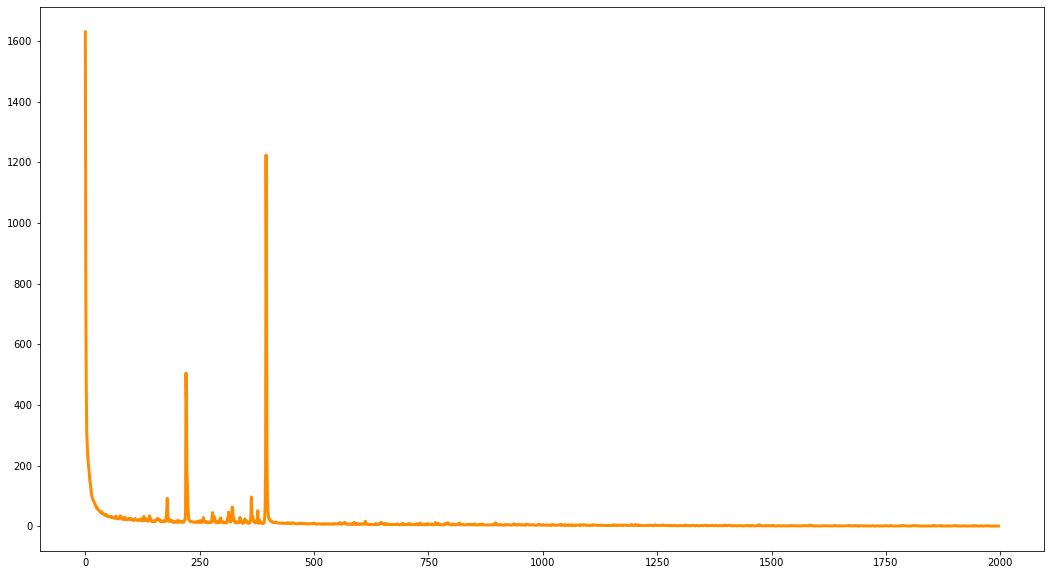

In [10]:
fig = plt.figure(figsize=(18, 10))
plt.plot(lose[3:],color="darkorange",linestyle="solid",linewidth=3,mec='darkorange',mfc='w',markersize=12)
plt.show()

In [10]:
model = un.UNet()
if torch.cuda.is_available():
    model.cuda()
model.load_state_dict(torch.load('output/15x25/UNetid1.pth'))
model.eval()
plot_data = []
if torch.cuda.is_available():
    model.cuda()
eval_loss = 0
eval_acc = 0
for batch_x, batch_y in test_loader:
    if torch.cuda.is_available():
        batch_x, batch_y = Variable(batch_x.cuda()), Variable(batch_y.cuda())
            
    out = model(batch_x)

    plot_data = out
    loss = loss_func(out, batch_y)
    eval_loss += loss.item()
    num_correct = abs(out - batch_y).sum()
    eval_acc += num_correct.item()
print('Val Loss: %.6f, Acc: %.3f' % (eval_loss / (math.ceil(len(val_data) / 7)),
                                     eval_acc / (len(val_data))))
plot_data1 = batch_y.cpu()
plot_data = plot_data.cpu()
print(plot_data.shape)
print(plot_data1.shape)

Val Loss: 3.656451, Acc: 1514.785
torch.Size([10, 1, 60, 100])
torch.Size([10, 1, 60, 100])


In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import r2_score

plot_data = plot_data.detach().numpy()
plot_data1 = plot_data1.detach().numpy()

# print(plot_data.shape)

plot_data = plot_data.reshape(len(plot_data),15*4,25*4)
plot_data1 = plot_data1.reshape(len(plot_data),15*4,25*4)

# print(plot_data.shape)

Plot_data = np.ones([len(plot_data),15,25])
Plot_data1 = np.ones([len(plot_data),15,25])

ken = np.ones([4, 4])/(4*4)

for i in range(len(plot_data)):
    Plot_data[i] = Conv2(plot_data[i], ken, 4, 4, 0)
    Plot_data1[i] = Conv2(plot_data1[i], ken, 4, 4, 0)

c = abs(Plot_data1-Plot_data)
# print(Plot_data.shape)

for j in range(len(Plot_data1)):

    print('Picture' + str(j))
    print('True1: '+ str(np.max(Plot_data1[j])))
    print('Estimate1: '+ str(np.max(Plot_data[j])))
    print('True2: '+ str(np.sort(Plot_data1[j].reshape(1,-1))[0][-2]))
    print('Estimate2: ' + str(np.sort(Plot_data[j].reshape(1,-1))[0][-2]))
    print('MAE:  '+str(mean_absolute_error(Plot_data1[j],Plot_data[j])))#Y_real为实际值，Y_pre为预测值
#     print('MSE:  '+str(mean_squared_error(plot_data1[j],plot_data[j])))
    print('RMSE:  '+str(np.sqrt(mean_squared_error(Plot_data1[j],Plot_data[j]))))
    a = np.cumsum(Plot_data[j])
    b = np.cumsum(Plot_data1[j])

    print('NE:  '+str(abs(a[-1]-b[-1])/b[-1]))
#     print('ME:  '+str(abs(a[-1]-b[-1])/(13*8)))
#     print('R2:  '+str(r2_score(plot_data1[j],plot_data[j])))
    print()
end_time = time.time()

run_time = round(end_time-begin_time)
# 计算时分秒
hour = run_time//3600
minute = (run_time-3600*hour)//60
second = run_time-3600*hour-60*minute
# 输出
print (f'该程序运行时间：{hour}小时{minute}分钟{second}秒')

Picture0
True1: 203.2962188720703
Estimate1: 197.27295112609863
True2: 202.44772338867188
Estimate2: 195.7489423751831
MAE:  0.05521930886558645
RMSE:  0.4765438858252476
NE:  0.025288300998406864

Picture1
True1: 202.63963317871094
Estimate1: 209.51700019836426
True2: 201.79576110839844
Estimate2: 199.16143798828125
MAE:  0.04977283274491007
RMSE:  0.44402624674283997
NE:  0.0072178578380192315

Picture2
True1: 203.2021026611328
Estimate1: 196.19178199768066
True2: 202.29220581054688
Estimate2: 193.77457237243652
MAE:  0.05612039966989929
RMSE:  0.5727441125856337
NE:  0.03881072139443718

Picture3
True1: 202.73800659179688
Estimate1: 221.34924221038818
True2: 201.27931213378906
Estimate2: 146.53077125549316
MAE:  0.21765409611669986
RMSE:  2.9871904659577013
NE:  0.08790164331418518

Picture4
True1: 204.0208740234375
Estimate1: 212.6014289855957
True2: 202.6131591796875
Estimate2: 186.6091890335083
MAE:  0.08934175598617486
RMSE:  0.9593692903430457
NE:  0.010810771990470522

Picture

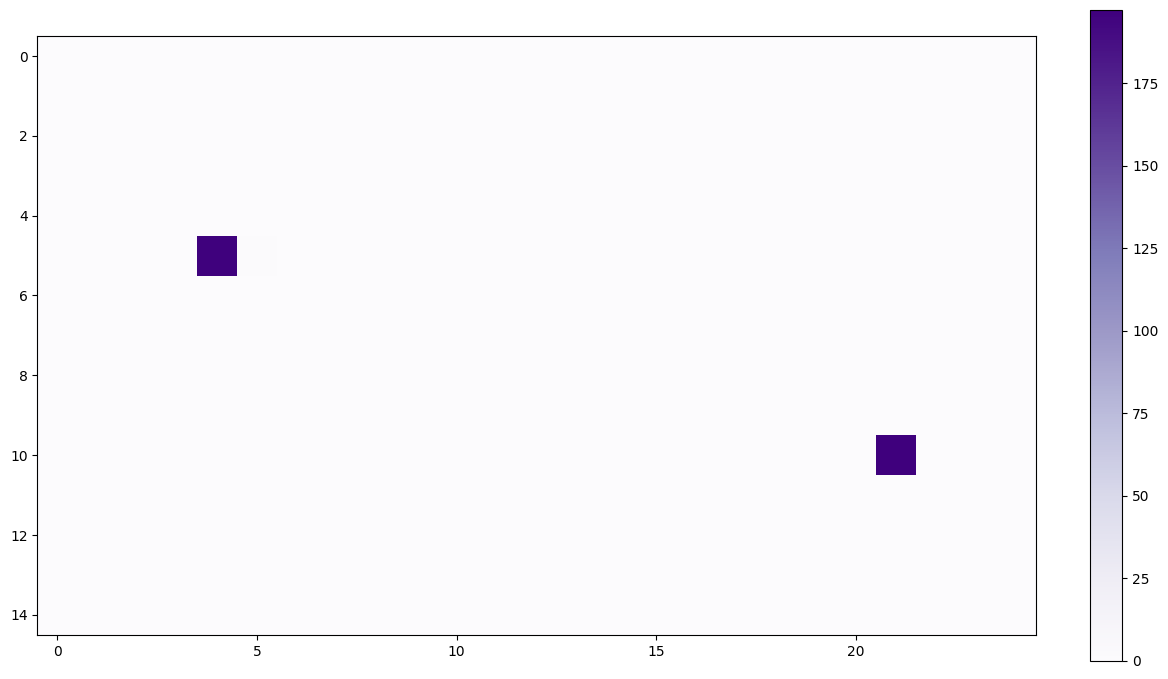

197.27295112609863
195.7489423751831


In [12]:
fig = plt.figure(figsize=(14, 18))
# plot_data = plot_data*(y_train_max - y_train_min)+y_train_min
# plot_data = plot_data.cpu()
# plot_data = plot_data.detach().numpy()

Plot_data = Plot_data.reshape(len(Plot_data),1,15,25)
# plot_data = plot_data.reshape(10,1,18,14)
# plot_data = plot_data.reshape(len(plot_data),1,8,13)

# print(Plot_data.shape)
# print(len(plot_data[1]))
for j in range(len(Plot_data[1])):
    plt.imshow(Plot_data[0][j], cmap='Purples')
#     plt.axis('off')
plt.colorbar(fraction=0.03, pad=0.05)
plt.show()
# plot_data = torch.from_numpy(plot_data)

print(np.max(Plot_data[0]))
# print(plot_data[3].shape)
# plot_data[3].reshape(1,-1)
# print(plot_data[3].reshape(1,-1).shape)
# print(plot_data[3].reshape(1,-1))
print(np.sort(Plot_data[0].reshape(1,-1))[0][-2])
# print(plot_data[4][0][5][3])
# print(torch.max(plot_data[0],0)[1])

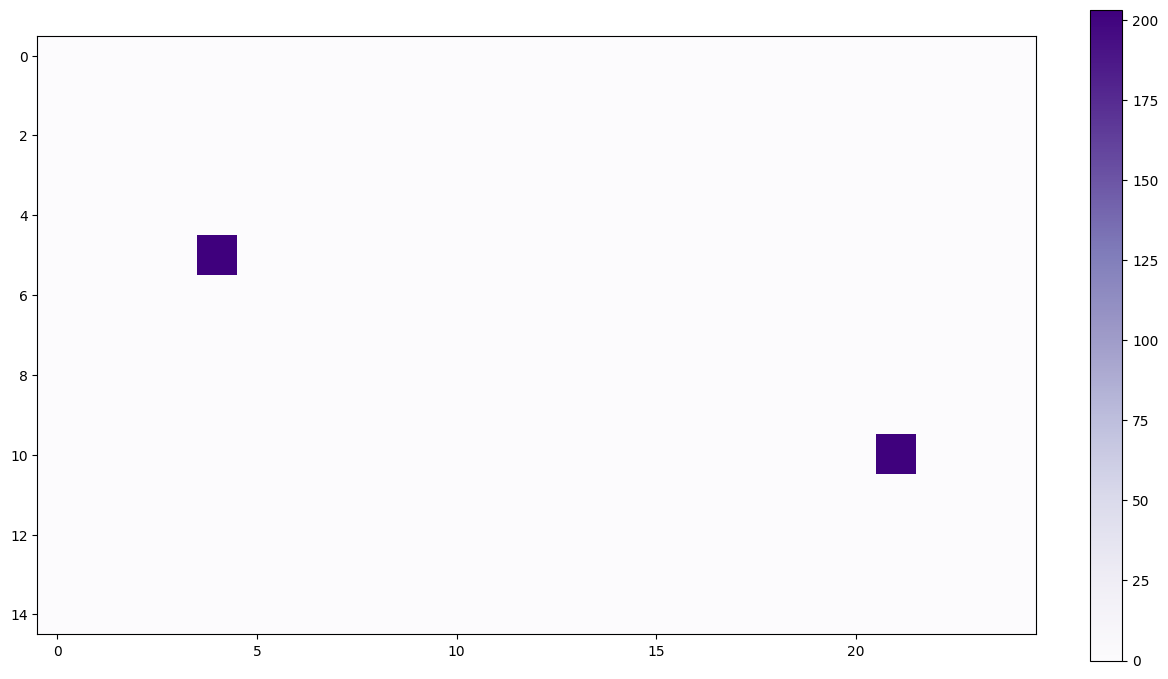

203.2962188720703
202.44772338867188


In [13]:
fig = plt.figure(figsize=(14, 18))
# plot_data1 = plot_data1*(y_train_max - y_train_min)+y_train_min

# plot_data1 = plot_data1.detach().numpy()

Plot_data1 = Plot_data1.reshape(len(Plot_data),1,15,25)
# plot_data1 = plot_data1.reshape(10,1,18,14)
# plot_data1 = plot_data1.reshape(len(plot_data1),1,8,13)

for j in range(len(Plot_data1[1])):
    plt.imshow(Plot_data1[0][j], cmap='Purples')
#     plt.axis('off')
plt.colorbar(fraction=0.03, pad=0.05)
plt.show()
# plot_data1 = torch.from_numpy(plot_data1)

print(np.max(Plot_data1[0]))
# print(np.sort(plot_data1[1])[-2])
print(np.sort(Plot_data1[0].reshape(1,-1))[0][-2])

# print(torch.max()[1])
# print(len(plot_data1))

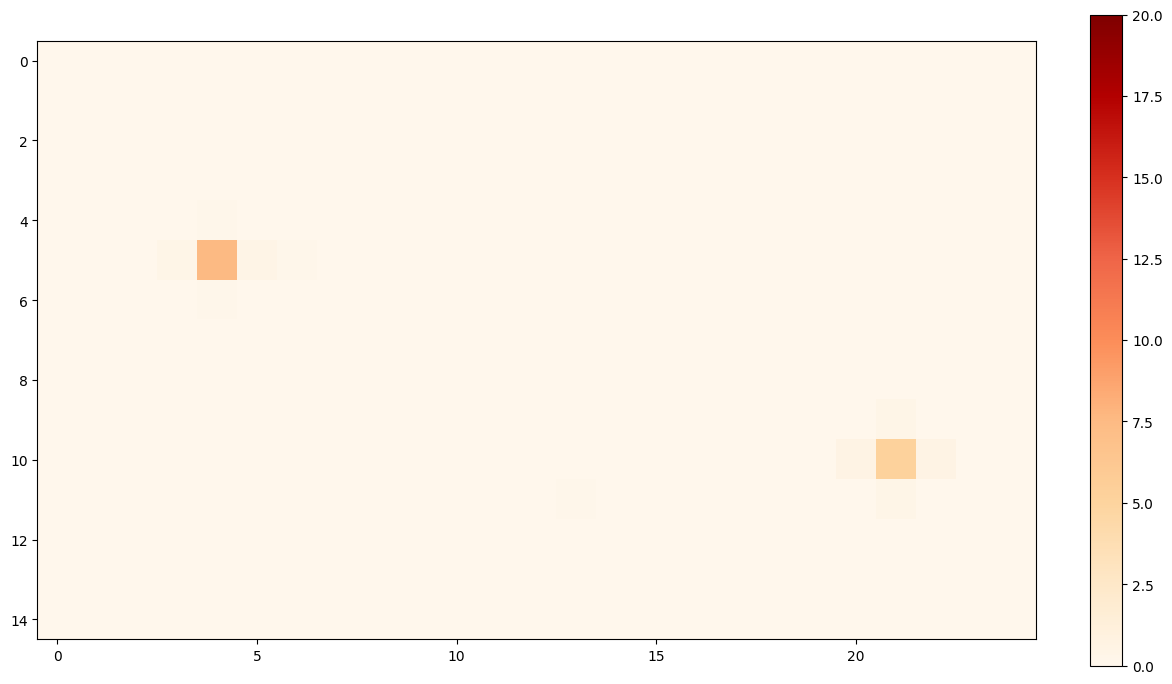

7.547276496887207


In [14]:
fig = plt.figure(figsize=(14, 18))

# c = c.detach().numpy()

c = c.reshape(len(plot_data),1,15,25)
# c = c.reshape(10,1,18,14)
# c = c.reshape(len(plot_data),1,8,13)

# print(c.shape)
# print(len(plot_data[1]))
for j in range(len(c[0])):
    plt.imshow(c[0][j], cmap='OrRd', vmin = 0, vmax = 20)
#     plt.axis('off')
plt.colorbar(fraction=0.03, pad=0.05)
plt.show()
# c = torch.from_numpy(c)

print(np.max(c[0]))
# print(np.sort(c[3])[-2])
# print(plot_data[4][0][5][3])
# print(torch.max(plot_data[0],0)[1])

In [15]:
# def Conv2(img, kernel, n, stride,p):
#     #img：输入图片；kernel：卷积核值；n：卷积核大小为n*n；stride:步长。
#     #return：feature map
#     h, w = img.shape
#     res_h = ((h+2*p-n)//stride)+1 #卷积边长计算公式：((n+2*p-k)/stride)+1
#     res_w = ((w+2*p -n)//stride)+1
#     res = np.zeros([res_h, res_w])
#     for i in range(res_h):
#         for j in range(res_w):
#             temp = img[i*stride:i*stride+n , j*stride:j*stride+n]
#             temp = np.multiply(kernel, temp)
#             res[i][j] = temp.sum()
#     return res

# if __name__ == '__main__':
#     A = np.ones([10, 15*4, 25*4])
#     B = np.ones([10, 15, 25])
#     ken = np.ones([4, 4])/(4*4)
#     for i in range(len(A)):
#         B[i] = Conv2(A[i], ken, 4, 4, 0)
# #     print("result：",Conv2(A, ken, 32, 32, 0))
# #     print(B)
#     print(B.shape)

In [16]:
# mid = np.ones([1, 1, 4, 4])
# # mid.dtype = 'float32'
# print(mid.shape)
# A = np.ones([100, 1, 15, 25])
# A = np.kron(A, mid)
# print(A.shape)

In [17]:
gc.collect()
torch.cuda.empty_cache()